# Automatic feature engineering in a linear system

In the [bivariate linear regression tutorial](LinearRegressionBivariate.html)[Notebook](LinearRegressionBivariate.ipynb), gave us the tools to perform linear regression on multiple variables. In the [bivariate Keras linear regression tutorial](LinearRegressionBivariate-Keras.html)[Notebook](LinearRegressionBivariate-Keras.ipynb), most of the plumbing of the optimization was delegated to Keras.

In this tutorial, we will use the [Galton dataset of people height](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/T0HSJ1). Starting from a simple regression using parents' heights to estimate the child's height, the model will be improved to take into account for the child's sex. Eventually, we will try to get the model to learn the feature through a two level neural net based on Keras.


### Learning goals:
- [Feature engineering](https://en.wikipedia.org/wiki/Feature_engineering) to manually improve the model
- Observe the extraction and combination of features by a neural net, that's called [feature learning](https://en.wikipedia.org/wiki/Feature_learning)
- Prescale training data and adjust scaling in predictions

In [ ]:
from tensorflow import keras
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
from sklearn import metrics, linear_model, model_selection, preprocessing
import pandas as pd

In [2]:
usingTensorBoard = False

## Helpers

In [3]:
def twinPlot(features, series, legend):
    """ Plot subplots horizontally """
    numPlots = len(features.columns)
    fig, axs = plt.subplots(1, numPlots, sharey=True, figsize=(16, 6))
    if numPlots == 1:
        t, v = features.iteritems()[0]
        for y in series:
            axs.scatter(v, y)
     #   axs[i].set_aspect('equal')
        axs.set_xlabel(t)
        axs.legend(legend)
        axs.set_title('Height [inch]')
    else:
        for i, c in enumerate(features.iteritems()):
            for y in series:
                axs[i].scatter(c[1], y)
          #  axs[i].set_aspect('equal')
            axs[i].set_xlabel(c[0])
        axs[0].legend(legend)
        axs[0].set_title('Height [inch]')

## Reading data

The choosen data model is the Galton dataset of human heights with parents' heights. It also contains the gender of each kid, that's the feature will attempt to automatically process.

In [4]:
df = pd.read_csv('Galton.txt', sep="\t") # http://www.randomservices.org/random/data/Galton.txt 
df.head()

,Family,Father,Mother,Gender,Height,Kids
0,1,78.5,67.0,M,73.2,4
1,1,78.5,67.0,F,69.2,4
2,1,78.5,67.0,F,69.0,4
3,1,78.5,67.0,F,69.0,4
4,2,75.5,66.5,M,73.5,4


Splitting train (80%) and test (20%)

In [5]:
(df_train, df_test) = model_selection.train_test_split(df, test_size=0.2)

### Data Preparation

We will first normalize the data before fitting the linear regression, in order to compare with the linear regression with neural net afterward.

Normalization is, for each feature, removing the mean and scaling the variance to 1. It is important in order to get equivalent convergence speeds on all features and proper regularization.

Inverse transformation will be necessary after prediction on train or test data.

Two scalers are used to handle separately the features (X) and the labels (Y)

In [6]:
scalerX = preprocessing.StandardScaler(copy=True, with_mean=True, with_std=True)
scalerX.fit(df_train[['Mother', 'Father']])
trainX_scaled = scalerX.transform(df_train[['Mother', 'Father']])
testX_scaled = scalerX.transform(df_test[['Mother', 'Father']])

scalerY = preprocessing.StandardScaler(copy=True, with_mean=True, with_std=True)
scalerY.fit(df_train[['Height']])
trainY_scaled = scalerY.transform(df_train[['Height']])

## Linear regression on the parents' heights

In [7]:
model1 = linear_model.LinearRegression()

model1.fit(trainX_scaled, trainY_scaled)
b1 = model1.intercept_
w1 = model1.coef_.reshape(-1)

print('Linear regression with 2 features, intercept = %.3f, weights = %.3f, %.3f' % (b1, w1[0], w1[1]))

Linear regression with 2 features, intercept = -0.000, weights = 0.163, 0.242


### Model evaluation

Mean squared error for global model : 10.872


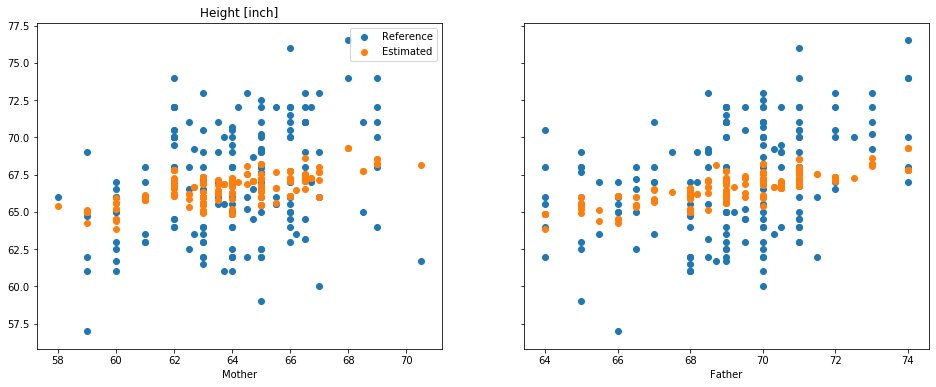

In [8]:
height_est1_scaled = model1.predict(testX_scaled)
height_est1 = scalerY.inverse_transform(height_est1_scaled)

mse1 = metrics.mean_squared_error(df_test['Height'], height_est1)
twinPlot(df_test[['Mother', 'Father']], [ df_test['Height'], height_est1], ['Reference', 'Estimated'])
print("Mean squared error for global model : %.3f" % mse1)

We may guess or check on the residus that we are missing some fundamental information : the sex of the kid.
Let's redo the linear regression with separate models for kids and girls.

## Linear regression on the parents' heights with gendered models

Let's create a specific linear regression for each sex and combine the results

Note: the scalers of the full dataset are used for both models in order to align with what is done for neural nets

In [9]:
girls_train = df_train['Gender'] == 'F'
girls_test = df_test['Gender'] == 'F'

trainX_girls_scaled = scalerX.transform(df_train[['Mother', 'Father']][girls_train])
trainY_girls_scaled = scalerY.transform(df_train[['Height']][girls_train])

model2_girl = linear_model.LinearRegression()

model2_girl.fit(trainX_girls_scaled, trainY_girls_scaled)
b2_girl = model2_girl.intercept_
w2_girl = model2_girl.coef_.reshape(-1)

In [10]:
boys_train = df_train['Gender'] == 'M'
boys_test = df_test['Gender'] == 'M'

trainX_boys_scaled = scalerX.transform(df_train[['Mother', 'Father']][boys_train])
trainY_boys_scaled = scalerY.transform(df_train[['Height']][boys_train])

model2_boy   = linear_model.LinearRegression()

model2_boy.fit(trainX_boys_scaled, trainY_boys_scaled)
b2_boy = model2_boy.intercept_
w2_boy = model2_boy.coef_.reshape(-1)

In [11]:
print('Linear regression with 2 features, fitting girls, intercept = %.3f, weights = %.3f, %.3f' % (b2_girl, w2_girl[0], w2_girl[1]))
print('Linear regression with 2 features, fitting boys,  intercept = %.3f, weights = %.3f, %.3f' % (b2_boy, w2_boy[0], w2_boy[1]))

Linear regression with 2 features, fitting girls, intercept = -0.735, weights = 0.209, 0.286
Linear regression with 2 features, fitting boys,  intercept = 0.730, weights = 0.196, 0.265


In [35]:
testX_girls_scaled = scalerX.transform(df_test[['Mother', 'Father']][girls_test])
testX_boys_scaled = scalerX.transform(df_test[['Mother', 'Father']][boys_test])

# Predict
height_est2_boy_scaled = model2_boy.predict(testX_boys_scaled)
height_est2_girl_scaled = model2_girl.predict(testX_girls_scaled)
# Inverse scale
height_est2_boy = scalerY.inverse_transform(height_est2_boy_scaled).reshape(-1)
height_est2_girl = scalerY.inverse_transform(height_est2_girl_scaled).reshape(-1)

mse2 = 1 / len(df_test) * (np.sum((df_test['Height'][boys_test] - height_est2_boy)**2) +
                           np.sum((df_test['Height'][girls_test] - height_est2_girl)**2))

print("Mean squared error for split boy/girl model : %.3f" % mse2)

Mean squared error for split boy/girl model : 4.009


We observe a significant change in the coefficients, and a sharp decrease of the MSE

## Baseline model with Keras

Let's build the equivalent gradient descent version of the model1, in order to perform a fair and verified comparison between the two inversion based and gradient descent based methods.

In [13]:
# Number of epochs
nEpoch3 = 512
nBatch3 = 128 # 32 is default
nFeatures3 = 2

# Model
model3 = keras.models.Sequential([
  keras.layers.Dense(1, activation='linear', input_shape=[nFeatures3],
                    kernel_regularizer=keras.regularizers.l2(0.0001))
])
model3.compile(optimizer='adam',
              loss=keras.losses.mean_squared_error,
              metrics=['mse'])

# Tensor board
callbacks = []
if usingTensorBoard:
    ks = keras.callbacks.TensorBoard(log_dir="./logs/", 
                                     histogram_freq=1, write_graph=True, write_grads=True, batch_size=1)
    callbacks = [ks]
    
# Fit
hist3 = model3.fit(trainX_scaled, trainY_scaled, 
                   epochs=nEpoch3, batch_size=nBatch3, validation_split = 0.2, verbose=0, callbacks=callbacks)

w3, b3 = model3.get_weights()
print('Scaled intercept = %.3f, Weights = ' % b3[0], w3.reshape(-1))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Scaled intercept = -0.001, Weights =  [0.12689024 0.24040157]


Verification, the intercepts and weights computed by the gradient descent are equal to the ones compted by Scikit Learn's linear regression. 

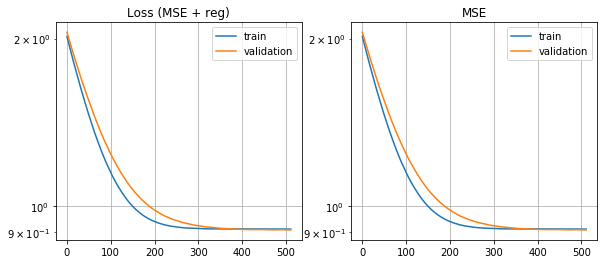

In [14]:
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.semilogy(hist3.history['loss'])
plt.semilogy(hist3.history['val_loss'])
plt.grid()
plt.legend(('train', 'validation'))
plt.title('Loss (MSE + reg)');
plt.subplot(1,3,2)
plt.semilogy(hist3.history['mean_squared_error'])
plt.semilogy(hist3.history['val_mean_squared_error'])
plt.grid()
plt.legend(('train', 'validation'))
plt.title('MSE');

Mean squared error for Keras baseline model : 10.996, original mse: 10.872


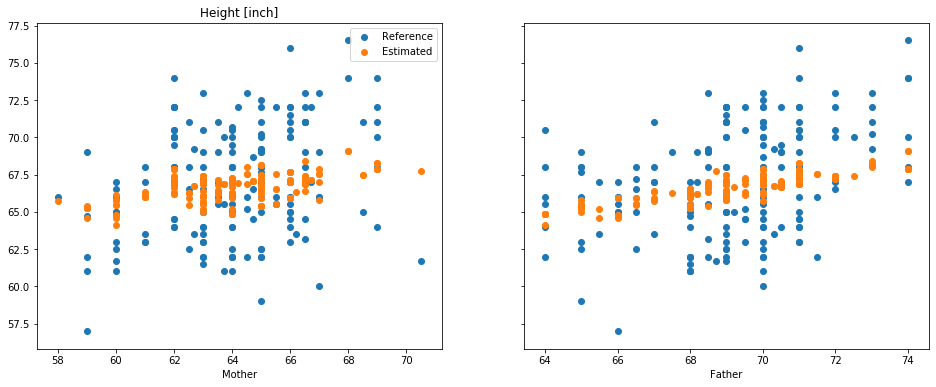

In [15]:
# Predict
height_est3_scaled =  model3.predict(testX_scaled)
# Inverse scale
height_est3 = scalerY.inverse_transform(height_est3_scaled)

mse3 = metrics.mean_squared_error(df_test['Height'], height_est3)

twinPlot(df_test[['Mother', 'Father']], [df_test['Height'], height_est3], ['Reference', 'Estimated'])
print("Mean squared error for Keras baseline model : %.3f, original mse: %.3f" % (mse3, mse1))

The MSE on the test set is similar to the one of linear regression.

Keras baseline model and method is validated.

## Model with gender in Keras

Let's add the gender into the Keras model. In order to get symetrical handling of both sexes, we are first encoding the sex with a one hot encoder that is going to create two binary features corresponding to the sex:

|sex|enc1|enc2|
|---|----|----|
| F | 1 | 0 |
| M | 0 | 1 |

In [54]:
np.concatenate((df_train['Gender'].to_numpy().reshape(-1,1), 
                genderEncoder.transform(df_train[['Gender']])), axis=1)[:3]

array([['M', 0.0, 1.0],
       ['F', 1.0, 0.0],
       ['M', 0.0, 1.0]], dtype=object)

In [55]:
# Number of epochs
nEpoch4 = 512
nBatch4 = 128 # 32 is default
nFeatures4 = 4

# Model
model4 = keras.models.Sequential([
  keras.layers.Dense(2, activation='linear', input_shape=[nFeatures4],
                     kernel_regularizer=keras.regularizers.l2(0.0001)),
  keras.layers.Dense(1, activation='linear', input_shape=[nFeatures4],
                     kernel_regularizer=keras.regularizers.l2(0.0001))
])
model4.compile(optimizer='adam',
              loss=keras.losses.mean_squared_error,
              metrics=['mse'])

# Tensor board
callbacks = []
if usingTensorBoard:
    ks = keras.callbacks.TensorBoard(log_dir="./logs/", 
                                     histogram_freq=1, write_graph=True, write_grads=True, batch_size=1)
    callbacks = [ks]
    
# Fit
xTrain4 = np.concatenate((trainX_scaled, 
                          genderEncoder.transform(df_train[['Gender']])), axis=1)
hist4 = model4.fit(xTrain4, trainY_scaled,
                   epochs=nEpoch4, batch_size=nBatch4, validation_split = 0.2, verbose=0, callbacks=callbacks)

In [56]:
model4.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2)                 10        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 3         
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________


In [75]:
weights4 = model4.get_weights()
weights4

[array([[-0.44874623,  0.11919507],
        [-0.67978543,  0.19561037],
        [-0.84660053, -1.0213903 ],
        [-0.31209952,  1.2262572 ]], dtype=float32),
 array([ 0.08054129, -0.11431135], dtype=float32),
 array([[-0.22448747],
        [ 0.69696194]], dtype=float32),
 array([-0.10896541], dtype=float32)]

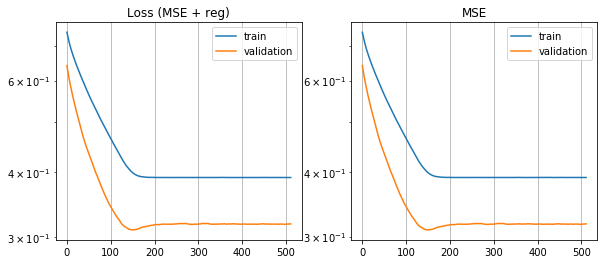

In [59]:
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.semilogy(hist4.history['loss'])
plt.semilogy(hist4.history['val_loss'])
plt.grid()
plt.legend(('train', 'validation'))
plt.title('Loss (MSE + reg)');
plt.subplot(1,3,2)
plt.semilogy(hist4.history['mean_squared_error'])
plt.semilogy(hist4.history['val_mean_squared_error'])
plt.grid()
plt.legend(('train', 'validation'))
plt.title('MSE');

Beware that this MSE results are on scaled data, thus lower than if on original data

Mean squared error for Keras model with genre : 4.257, original MSE : 4.247


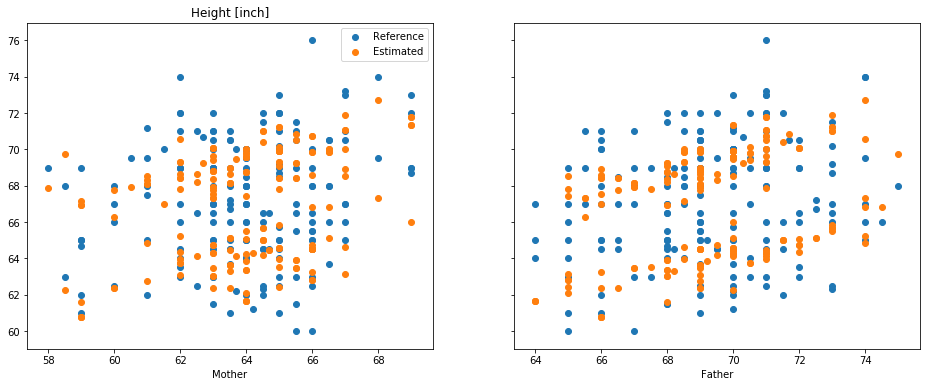

In [35]:
testX_scaled4 = np.concatenate((scalerX.transform(df_test[['Mother', 'Father']]), 
                         genderEncoder.transform(df_test[['Gender']])), axis=1)
height_est_scaled4 =  model4.predict(testX_scaled4)

height_est4 = scalerY.inverse_transform(height_est_scaled4)
mse4 = metrics.mean_squared_error(df_test['Height'], height_est4)

twinPlot(df_test[['Mother', 'Father']], [df_test['Height'], height_est4], ['Reference', 'Estimated'])
print("Mean squared error for Keras model with genre : %.3f, original MSE : %.3f" % (mse4, mse2))

## Comparison of the two gendered models

The mode2 in which prediction is using either girl or boy regression model is equivalent as a two layer network : 
1. compute the predictions using both the girl and boy regression models, weigh each of the outputs with the one hot encoded value of actual gender
2. sum the two contributions

Using this topology, we may compare model2 and model4 in following tables.

### Stage 1 : two neurons 

| Neuron 1                   | Mother | Father | Is a girl | Is a boy | Intercept |
|----------------------------|--------|--------|-----------|----------|-----------|
| Linear regressions combined| 0.212  | 0.293  |   1.0     |   0.0    | -0.734    |
| Auto trained neural net    | 0.245  | -0.351 |  -0.729   |   0.168  | 0.168     |

| Neuron 2                   | Mother | Father | Is a girl | Is a boy | Intercept |
|----------------------------|--------|--------|-----------|----------|-----------|
| Linear regressions combined| 0.230  | 0.299  |   0.0     |   1.0    | 0.715     |
| Auto trained neural net    | 0.202  | -0.940 |  0.456    |   0.515  | -0.236    |


### Stage 2 : combiner

| Neuron 3                   | In1    | In2    | Intercept |
|----------------------------|--------|--------|-----------|
| Linear regressions combined| 1      | 1      |   0.0     |
| Auto trained neural net    | 1.70   | -0.944 |  0.256    |


The figures are quite different in magnitude and in sign!

### Step by step example on the first person

#### With "2 stage" gendered linear regression

In [32]:
s1 = df_test.head(1)
s1

,Family,Father,Mother,Gender,Height,Kids
302,75,70.0,64.7,M,68.7,7


In [71]:
s1_scaled = scalerX.transform(s1[['Mother', 'Father']])
s1_scaled

array([[0.26569455, 0.2964123 ]])

In [72]:
s1_encoded = genderEncoder.transform(s1[['Gender']]).reshape(-1)
p2_out1_girl = model2_girl.predict(s1_scaled).reshape(-1)[0]
p2_out1_boy  = model2_boy.predict(s1_scaled).reshape(-1)[0]
print("1st Stage outputs = %.3f * %d, %.3f * %d" % (p2_out1_girl, s1_encoded[0], p2_out1_boy, s1_encoded[1]))

1st Stage outputs = -0.595 * 0, 0.860 * 1


In [84]:
p2_out = np.sum(np.matmul([p2_out1_girl, p2_out1_boy], s1_encoded))
# Inverse scaling
p2_out_unscaled = scalerY.inverse_transform([p2_out]).reshape(-1)[0]
print("Prediction with combined linear regressors = %.3f inch" % p2_out_unscaled)

Prediction with combined linear regressors = 69.754 inch


#### With the 2 layer neural net

In [70]:
s1_in = np.concatenate((s1_scaled, s1_encoded.reshape(1,-1)), axis=1)
s1_in

array([[0.26569455, 0.2964123 , 0.        , 1.        ]])

In [79]:
p4_out1 = np.matmul(s1_in, weight4[0]) + weights4[1]
p4_out1

array([[-0.55228442,  1.20159665]])

In [82]:
p4_out2 = (np.matmul(p4_out1, weight4[2]) + weights4[3]).reshape(-1)[0]
p4_out2

0.8524826535724519

In [83]:
p4_out_unscaled = scalerY.inverse_transform([p4_out2]).reshape(-1)[0]
print("Prediction with 2 stage neural net = %.3f inch" % p4_out_unscaled)

Prediction with 2 stage neural net = 69.727 inch


Almost the same prediction is made but following rather different paths, showing that the gradient descent optimization's result is not unique.

## Conclusion

Using a little feature engineering (one hot encoding) and feature learning capabilities of the neural net, we have been able to learn a model taking into acount for the gender of the target child.

This simple example is extended in the large classification frameworks like AlexNet, VGG or GoogLeNet: they are able to combine features extracted from images to eventually classify objects and animals.

The drawbacks are :
- More complex models : the provided model has 2 layers and 13 parameters, whereas the manually engineered model has 2*3=6 parameters
- Complex and tricky optimizations : the gradient descent on multi-layer neural networks requires attention and skills to get a repeatable and generalizable results

### Where to go from here :

Compare with the [two feature binary classification using logistic regression using Keras](../classification/ClassificationContinuous2Features-Keras.html) ([Notebook](../classification/ClassificationContinuous2Features-Keras.ipynb]))

[Multi-class classification with Keras](../classification/ClassificationMulti2Features-Keras.html) ([Notebook](../classification/ClassificationMulti2Features-Keras.ipynb))